# TensorFlow-GPU model for MNIST dataset

In [ ]:
# Version 3
# 
# From begining install Tensorflow-GPU by 
# https://www.thehardwareguy.co.uk/install-tensorflow-gpu
# and look to this comment below article: 
# "In tensorflow = 2.1.0, it is not needed to install keras separately 
# (pip install keras not needed) and it will be installed (keras =2.2.4-tf) 
# as a dependency of tensorflow-gpu with "conda install" itself.

# it's work for me in Win10
# GOOD LUCK :)

In [1]:
# Imports
import os

import tensorflow as tf
# uncomment next 2 lines to start on GPU
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class Data:
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.x_train, self.y_train),(self.x_test, self.y_test) = mnist.load_data(path="mnist.npz")
        # normalization
        self.x_train = self.x_train / 255.0
        self.x_test = self.x_test / 255.0

In [175]:
class Model:
    def __init__(self, hidden_layer, learning_rate):
        self.name = "mnist"
        self.save_folder = os.path.join(os.getcwd(), 
                                        "training_mnist_gpu")
        if not os.path.exists(self.save_folder):
            os.mkdir(self.save_folder)
        self.checkpoint_path = os.path.join(self.save_folder, 
                                            "cp.ckpt")
        
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(hidden_layer, 
                                  activation='relu'),
            tf.keras.layers.Dropout(learning_rate),
            tf.keras.layers.Dense(10, 
                                  activation='softmax')
        ])
        
        self.model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

    def train(self, data, epochs):
        checkpoint_dir = os.path.dirname(self.checkpoint_path)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq=10*len(data.x_train),
                                                         verbose=1)
        self.model.fit(data.x_train, 
                       data.y_train, 
                       epochs=epochs,
                       validation_data=(data.x_train, data.y_train),
                       callbacks=[cp_callback])

        return self.model.evaluate(x=data.x_test, 
                                   y=data.y_test, 
                                   verbose=1)

In [ ]:
hidden_layer=128

# Best values (acc=0.9828)
# ep_list = [15]
# lr_list = [0.15]

# Short exploratory
# ep_list = [3, 5, 7, 10, 12, 15]
# lr_list = [0.15, 0.1, 0.05, 0.01]

# Exploratory values - uncomment to train on various parameters
lr_list = [0.2, 0.15, 0.125, 0.1, 0.075, 0.05, 0.025]
ep_list = range(6, 22, 3)

data = Data()

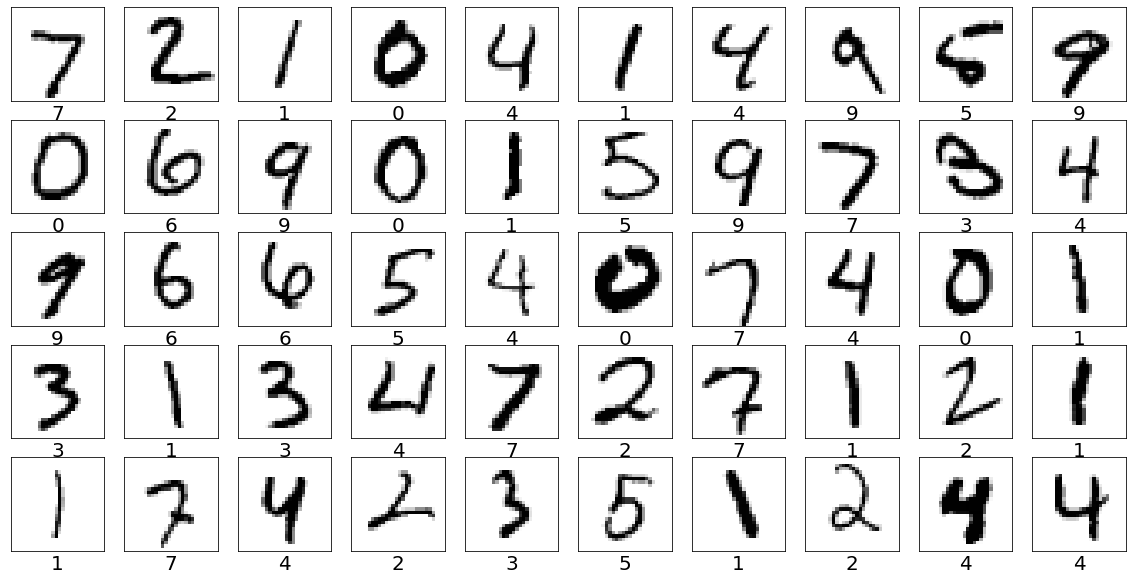

In [193]:
# Visual test for test_data
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data.x_test[i], cmap=plt.cm.binary)
    plt.xlabel(data.y_test[i], size=20)
    plt.grid(False)
plt.show()

In [ ]:
results = list()
best_acc = 0
cycle = 1
all_cycles = len(lr_list) * len(ep_list)
for lr in lr_list:
    for ep in ep_list:
        print(f"\n--- cycle {cycle} of {all_cycles} ---")
        print(f"learning_rate={lr}, num_ep={ep}")
        
        M = Model(hidden_layer, lr)
        loss, acc = M.train(data, ep)
        
        # save best
        if acc > best_acc:
            params = f"hl{hidden_layer}_lr{int(lr*10000)}_ep{ep}"
            model_filename = f"{M.name}_{int(acc*10000)}({params}).h5"
            M.model.save(os.path.join(M.save_folder, model_filename))
            print(f"model saved to {model_filename}")
            best_acc = acc
        
        results.append({'n': cycle, 'lr': lr, 'ep': ep, 'loss': loss, 'acc': acc})
        cycle += 1

In [177]:
# Show me best 5 in table
results_df = pd.DataFrame(columns=['n', 'lr', 'ep', 'loss', 'acc'])
results_df = results_df.append(results, ignore_index=True).sort_values('acc', ascending=False)
print(results_df.head())

     n     lr  ep      loss     acc
9   10  0.150  15  0.071436  0.9828
11  12  0.150  21  0.087528  0.9816
16  17  0.125  18  0.081224  0.9816
28  29  0.075  18  0.075384  0.9813
33  34  0.050  15  0.083562  0.9812


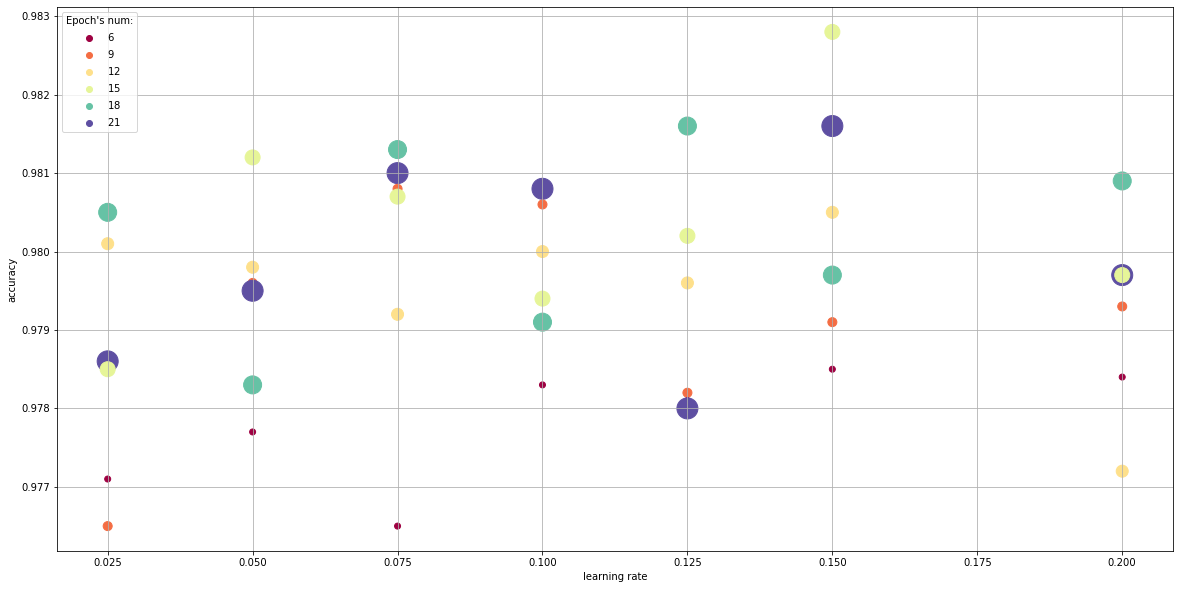

In [206]:
# Show me graph
g = results_df[['ep', 'lr', 'acc']]

fig, ax = plt.subplots(figsize=(20,10))


scatter = ax.scatter(x='lr', y='acc', 
                     data=g, 
                     s=list(map(lambda a: a*a, g['ep'])),
                     c='ep',
                     alpha=1,
                     cmap="Spectral")

plt.ylabel('accuracy')
plt.xlabel('learning rate')

ax.legend(*scatter.legend_elements(), 
          loc="upper left", 
          title="Epoch's num:")
ax.grid(True)
plt.show()